In [1]:
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO

In [2]:
interpro_cols = columns = [
    "accession",
    "sequence_md5",
    "sequence_length",
    "analysis",
    "signature_accession",
    "signature_description",
    "start",
    "stop",
    "score",
    "status",
    "date",
    "interpro_accession",
    "interpro_description",
    "go",
    "pathway",
]

In [3]:
df_ucyna = pd.read_csv('../results/ucyna_proteins_interpro.tsv', sep='\t')
df_cyano = pd.read_csv('../results/crocosphaera_proteins_interpro.tsv', sep='\t')
df_cyano.columns = interpro_cols
df_ucyna.columns = interpro_cols

In [ ]:
df1 = df_cyano.copy()
df1['pathway'] = df_cyano[df_cyano['pathway'] != '-']['pathway'].map(lambda x: x.split('|'))
df1= df1.explode('pathway').groupby('pathway')['accession'].apply(list).reset_index()


,pathway,accession
0,MetaCyc:PWY-0,"[WP_009544560.1, WP_009544560.1, WP_009544717...."
1,MetaCyc:PWY-1001,"[WP_009546002.1, WP_009546002.1, WP_009546002...."
2,MetaCyc:PWY-101,"[WP_009545187.1, WP_009545708.1, WP_009544415...."
3,MetaCyc:PWY-102,"[WP_009544469.1, WP_009544469.1, WP_198019415...."
4,MetaCyc:PWY-1042,"[WP_009544560.1, WP_009544560.1, WP_009544717...."
...,...,...
14043,Reactome:R-XTR-9840373,"[WP_009545016.1, WP_009545016.1, WP_009546769...."
14044,Reactome:R-XTR-9854311,"[WP_009545187.1, WP_009545708.1, WP_009543802...."
14045,Reactome:R-XTR-9856872,"[WP_009544560.1, WP_009544560.1, WP_009547075...."
14046,Reactome:R-XTR-9857492,"[WP_009543486.1, WP_009543486.1, WP_009543486...."


In [8]:
import pandas as pd
import requests

def fetch_reactome_info(pathway_id):
    """
    Given a Reactome pathway identifier in the form of: Reactome:R-HSA-12345
    query the Reactome ContentService for more semantic information.
    Returns a dictionary with pathway information including displayName and species.
    """
    reactome_id = pathway_id.split(":", 1)[-1]
    url = f"https://reactome.org/ContentService/data/query/{reactome_id}"
    try:
        r = requests.get(url)
        r.raise_for_status()
        info = r.json()
        return {
            "reactome_id": reactome_id,
            "displayName": info.get("displayName", "unknown"),
            "species": info.get("speciesName", "unknown"),
            "definition": info.get("summation", [{}])[0].get("text", "No description available"),
            "last_updated": info.get("lastUpdatedDate", "unknown")
        }
    except requests.exceptions.RequestException:
        return {
            "reactome_id": reactome_id,
            "displayName": "N/A",
            "species": "N/A",
            "definition": "N/A",
            "last_updated": "N/A"
        }

def analyze_reactome_losses(csv_path="results/pathway_completeness.csv"):
    """
    - Loads the CSV produced by pathway_completeness.py
    - Filters to Reactome pathways
    - Fetches pathway info from the Reactome Content Service
    - Prints missing UCYN-A proteins
    References: https://reactome.org/dev/content-service
    """
    df = pd.read_csv(csv_path)

    # Convert to string and fill NaN to avoid attribute errors on .split()
    for col in ["crocosphaera_protein_ids", "ucyna_protein_ids"]:
        if col in df.columns:
            df[col] = df[col].fillna("").astype(str)

    # Filter to Reactome only
    reactome_df = df[df["pathway"].str.startswith("Reactome:")].copy()

    # Focus on incomplete pathways (completeness < 100); just examine a few
    incomplete = reactome_df[reactome_df["completeness"] < 100].copy()
    incomplete = incomplete.head(5)

    # Gather Reactome metadata
    incomplete["reactome_info"] = incomplete["pathway"].apply(fetch_reactome_info)

    # Summarize which proteins are lost
    for idx, row in incomplete.iterrows():
        reactome_id = row["pathway"]
        reactome_data = row["reactome_info"]
        missing = row["missing_count"]

        # Split out the lists of proteins safely
        croco_proteins = row["crocosphaera_protein_ids"].split(",")
        ucyna_proteins = row["ucyna_protein_ids"].split(",")

        lost_proteins = [p for p in croco_proteins if p not in ucyna_proteins]

        # Print overview
        print(f"\nPathway: {reactome_id}")
        print(f"   Name: {reactome_data['displayName']}")
        print(f"   Species: {reactome_data['species']}")
        print(f"   Missing count: {missing}")
        print(f"   Lost proteins (Crocosphaera → not in UCYN-A): {lost_proteins}")

# Usage example:
# analyze_reactome_losses("results/pathway_completeness.csv")

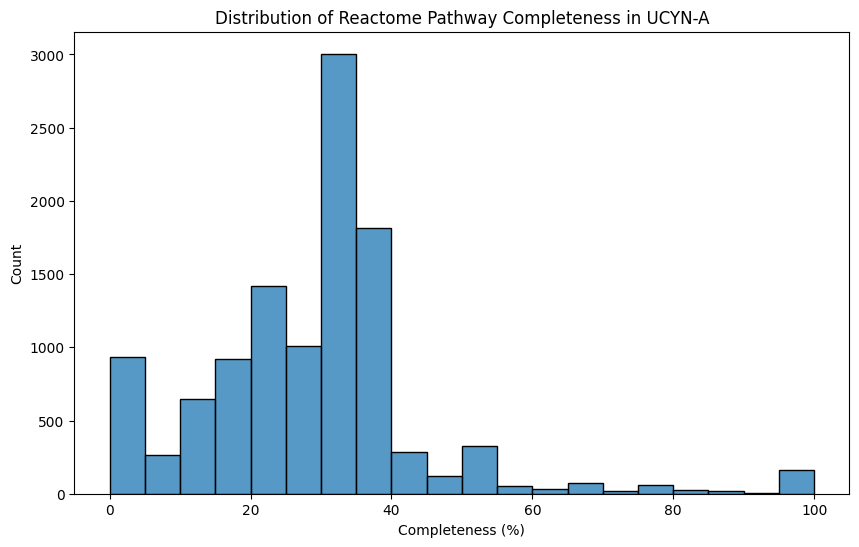

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import subprocess
import tempfile
import os

# Load pathway completeness results
df = pd.read_csv('../results/pathway_completeness.csv')

# Filter for Reactome pathways only
reactome_df = df[df['pathway'].str.startswith('Reactome:')]

reactome_less_than_100 = reactome_df[reactome_df['completeness'] <= 100]

# 1. Plot distribution of pathway completeness
plt.figure(figsize=(10, 6))
sns.histplot(data=reactome_less_than_100, x='completeness', bins=20)
plt.title('Distribution of Reactome Pathway Completeness in UCYN-A')
plt.xlabel('Completeness (%)')
plt.ylabel('Count')
plt.show()

In [13]:
# 2. Extract lost protein sequences
def get_lost_proteins(row):
    """Get proteins present in Crocosphaera but not in UCYN-A"""
    croco_proteins = set(row['crocosphaera_protein_ids'].split(',')) if pd.notna(row['crocosphaera_protein_ids']) else set()
    ucyna_proteins = set(row['ucyna_protein_ids'].split(',')) if pd.notna(row['ucyna_protein_ids']) else set()
    return croco_proteins - ucyna_proteins

# Create a set of all lost proteins
all_lost_proteins = set()
for _, row in reactome_df[reactome_df['completeness'] < 100].iterrows():
    all_lost_proteins.update(get_lost_proteins(row))

In [35]:
# Extract sequences for lost proteins
lost_sequences = []
with open('../data/crocosphaera_proteins.fasta', 'r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        if record.id in all_lost_proteins:
            lost_sequences.append(record)

In [46]:
# write lost sequences to file
with open('../results/lost_proteins.fasta', 'w') as handle:
    SeqIO.write(lost_sequences, handle, 'fasta')

In [47]:
# Read Muscle alignment
aligned_sequences = SeqIO.parse('../results/lost_sequences_aligned.fa', 'fasta')

FileNotFoundError: [Errno 2] No such file or directory: '../results/lost_sequences_aligned.fa'

In [38]:
# Write alignments to file
SeqIO.write(aligned_sequences, '../results/lost_proteins_aligned.fasta', 'fasta')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Align import AlignInfo
from Bio import AlignIO
import warnings

# Color scheme for amino acids
aa_colors = {
    'A': '#FF9966', 'C': '#FFCC00', 'D': '#FF0000', 'E': '#CC0033',
    'F': '#00FF00', 'G': '#FF9999', 'H': '#0066CC', 'I': '#66CC99',
    'K': '#6600CC', 'L': '#33CC00', 'M': '#00FFFF', 'N': '#CC00CC',
    'P': '#FFCC99', 'Q': '#FF00CC', 'R': '#0000FF', 'S': '#FF3300',
    'T': '#FF6600', 'V': '#99CC00', 'W': '#00CCFF', 'Y': '#66CCFF',
    '-': '#FFFFFF', '.': '#FFFFFF', '*': '#000000'
}

def compute_alignment_scores(alignment):
    """Compute consensus scores for each sequence in the alignment"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        summary_align = AlignInfo.SummaryInfo(alignment)
        consensus = summary_align.dumb_consensus()
    
    scores = []
    for record in alignment:
        score = sum(1 for a, b in zip(record.seq, consensus) if a == b)
        scores.append((score, record))
    
    return sorted(scores, key=lambda x: x[0], reverse=True)

def msa_to_color_matrix(sorted_alignment):
    """Convert alignment to RGB color matrix"""
    alignment = [str(record.seq).upper() for _, record in sorted_alignment]
    num_sequences = len(alignment)
    seq_length = len(alignment[0])
    
    color_matrix = np.zeros((num_sequences, seq_length, 3))
    
    for i, seq in enumerate(alignment):
        for j, aa in enumerate(seq):
            color = aa_colors.get(aa, '#FFFFFF')
            color_matrix[i, j] = [int(color[k:k+2], 16) / 255.0 for k in (1, 3, 5)]
    
    return color_matrix

# Create alignment object from your sequences
from Bio.Align import MultipleSeqAlignment
msa = MultipleSeqAlignment(aligned_sequences)

# Compute scores and color matrix
sorted_alignment = compute_alignment_scores(msa)
color_matrix = msa_to_color_matrix(sorted_alignment)

# Calculate consensus scores across positions
consensus_scores = []
for i in range(msa.get_alignment_length()):
    column = msa[:, i]
    most_common = max(set(column), key=column.count)
    score = column.count(most_common) / len(column)
    consensus_scores.append(score)

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), 
                              gridspec_kw={'height_ratios': [0.5, 2]})

# Plot consensus scores
with sns.plotting_context("paper", font_scale=1.3):
    sns.set_style("ticks")
    ax1.plot(range(1, len(consensus_scores) + 1), consensus_scores)
    ax1.set_xlim(0, msa.get_alignment_length())
    ax1.set_xticks([])
    ax1.set_ylabel('Consensus Score')
    ax1.set_title('Multiple Sequence Alignment', fontsize=20)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, linestyle='--', alpha=0.7)
    sns.despine(ax=ax1, bottom=True)

# Plot alignment
im = ax2.imshow(color_matrix, aspect='auto', interpolation='nearest')
ax2.set_xlabel("Sequence Position", labelpad=10)
ax2.set_ylabel("Sequences", labelpad=10)
ax2.set_xlim(0, msa.get_alignment_length())
ax2.set_yticks([])
sns.despine(ax=ax2, left=True)

# Adjust layout
plt.subplots_adjust(wspace=0, hspace=0.01)
plt.tight_layout()
plt.show()